<a href="https://colab.research.google.com/github/jkarthiknai/Loan-Prediction/blob/main/Loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
import operator

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [198]:
# Reading the csv data file
df = pd.read_csv("Training.csv")
df.info()
print(len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111107 entries, 0 to 111106
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       111107 non-null  object 
 1   Customer ID                   111107 non-null  object 
 2   Loan Status                   111107 non-null  object 
 3   Current Loan Amount           111107 non-null  int64  
 4   Term                          111107 non-null  object 
 5   Credit Score                  89769 non-null   float64
 6   Years in current job          106414 non-null  object 
 7   Home Ownership                111107 non-null  object 
 8   Annual Income                 89769 non-null   float64
 9   Purpose                       111107 non-null  object 
 10  Monthly Debt                  111107 non-null  object 
 11  Years of Credit History       111107 non-null  float64
 12  Months since last delinquent  52104 non-null

/tmp/ipython-input-198-4057409386.py:2: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Training.csv")


In [199]:
# Checking if there are duplicate observations
df['Loan ID'].value_counts()

,count
Loan ID,
26e3e4f3-7442-4b68-bc2b-a9c4567f67ce,2
7934a353-b3c5-430e-b7fb-03ff163aac20,2
4e515bf9-3d42-4008-9e7f-0f5b11473156,2
b58e30b1-347e-4f3c-830b-b337635dab22,2
13c34f9c-8546-480a-86b9-69f83568b37c,2
...,...
18cf82cd-f0e6-452e-8429-2a1e70b056ec,1
cead3a3f-1294-4558-9688-60b92eb2d369,1
18e58e4b-90fc-4248-99f6-02ed33e8310f,1


In [200]:
# There are duplicate observations
# Hence, deleting duplicates keeping the first alone
df.drop_duplicates(subset='Loan ID', keep='first', inplace=True)
print(len(df))

88910


<Axes: xlabel='Loan Status', ylabel='count'>

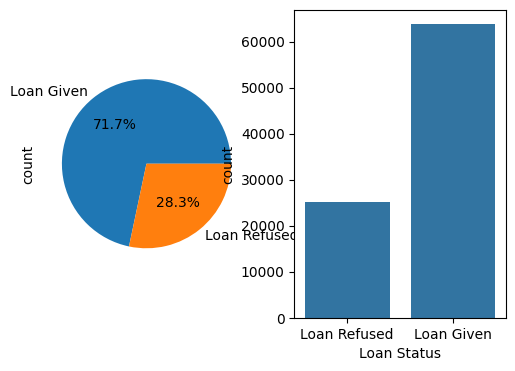

In [201]:
# Checking for data imbalance
fig, ax = plt.subplots(1,2,figsize=(6,4))
df['Loan Status'].value_counts().plot.pie(autopct = "%1.1f%%", ax=ax[0])
sns.countplot(x='Loan Status', data=df, ax=ax[1])
# Imbalanced data 71.7% : 28.3% (loan refused)

In [202]:
# Exploring Data
df['Current Loan Amount'].describe()

,Current Loan Amount
count,8.891000e+04
mean,1.433878e+07
std,3.502996e+07
min,4.910000e+02
25%,8.283000e+03
50%,1.435500e+04
75%,2.448500e+04
max,1.000000e+08


In [203]:
df['Current Loan Amount'].isnull().sum()

np.int64(0)

<Axes: ylabel='Frequency'>

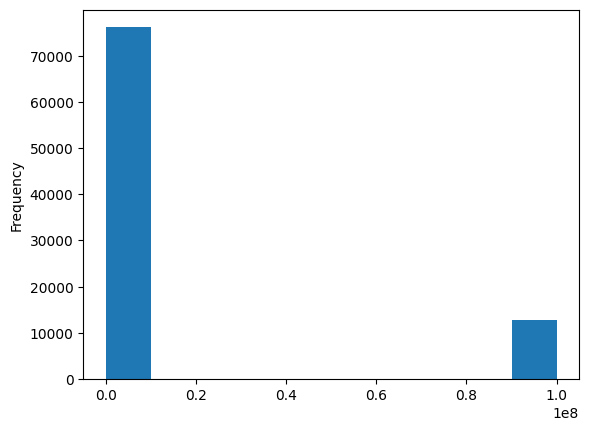

In [204]:
df['Current Loan Amount'].plot(kind='hist', bins=10)
# there are a few high current loan amounts

In [205]:
# Finding interquartile range, lower and upper bound values
q1 = df['Current Loan Amount'].quantile(0.25)
q2 = df['Current Loan Amount'].quantile(0.5)
q3 = df['Current Loan Amount'].quantile(0.75)

iqr = q3 - q1
print(q1, q2, q3, iqr)
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print(lower)
print(upper)
# There are outliers as the lower bound has -ve values for this feature.
print(df['Current Loan Amount'][(df['Current Loan Amount'] >= lower) &
(df['Current Loan Amount'] <= upper)].value_counts())


8283.0 14355.0 24485.0 16202.0
-16020.0
48788.0
Current Loan Amount
10151    25
8066     23
10156    23
9771     22
9941     22
         ..
23416     1
19074     1
5196      1
31226     1
28988     1
Name: count, Length: 22080, dtype: int64


In [206]:
print(df['Current Loan Amount'][(df['Current Loan Amount'] >= upper)].value_counts())
print(df['Loan Status'][df['Current Loan Amount']==99999999].value_counts())
print(df.loc[df['Current Loan Amount']==99999999, 'Loan Status'].value_counts())

# Observing deeper into this feature shows more instances of the current loan amount==99999999

Current Loan Amount
99999999    12738
Name: count, dtype: int64
Loan Status
Loan Given    12738
Name: count, dtype: int64
Loan Status
Loan Given    12738
Name: count, dtype: int64


In [207]:
# Loan status distribution wrt current loan amount
df.loc[df['Current Loan Amount']<99999999, 'Loan Status'].value_counts()

,count
Loan Status,
Loan Given,50999
Loan Refused,25173


In [208]:
df['Current Loan Amount'].isnull().sum()

np.int64(0)

In [209]:
df['Current Loan Amount'].describe()

,Current Loan Amount
count,8.891000e+04
mean,1.433878e+07
std,3.502996e+07
min,4.910000e+02
25%,8.283000e+03
50%,1.435500e+04
75%,2.448500e+04
max,1.000000e+08


In [210]:
df['Current Loan Amount'][df['Current Loan Amount']<99999999].describe()
# There is a significance difference in the summary statistics if 99999999 is ignored for summary calculation. There are less likely changces for an exact loan amount 99999999

,Current Loan Amount
count,76172.000000
mean,13933.915756
std,8235.921922
min,491.000000
25%,7810.000000
50%,12038.000000
75%,19351.000000
max,35875.000000


In [211]:
# Finding correlations among numerical features
filt_df = df[(df['Current Loan Amount']!=99999999) & (df['Current Loan Amount'].notnull())]

cor=filt_df[['Current Loan Amount','Annual Income','Months since last delinquent','Number of Credit Problems','Current Credit Balance','Number of Open Accounts', 'Years of Credit History']].corr()
print(cor)

# Annual Income, Current credit balance have slight correlations

                              Current Loan Amount  Annual Income  \
Current Loan Amount                      1.000000       0.329878   
Annual Income                            0.329878       1.000000   
Months since last delinquent            -0.039258      -0.079377   
Number of Credit Problems               -0.071351      -0.006359   
Current Credit Balance                   0.322122       0.276285   
Number of Open Accounts                  0.199934       0.134765   
Years of Credit History                  0.150790       0.142307   

                              Months since last delinquent  \
Current Loan Amount                              -0.039258   
Annual Income                                    -0.079377   
Months since last delinquent                      1.000000   
Number of Credit Problems                         0.098809   
Current Credit Balance                           -0.027509   
Number of Open Accounts                          -0.034196   
Years of Credit Histo

12038.0
14355.0


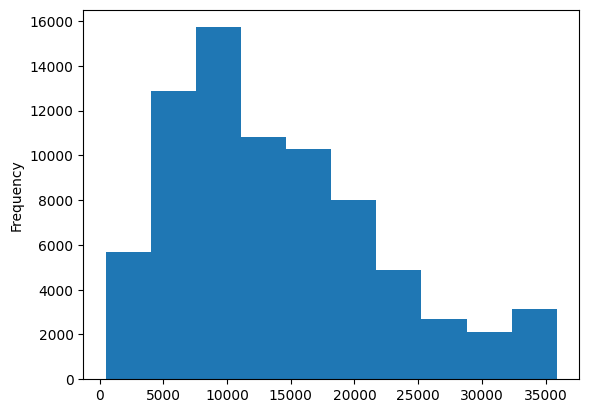

In [212]:
# Plot of the CLA leaving the highest amount
df.loc[df['Current Loan Amount'] < 99999999]['Current Loan Amount'].plot(kind='hist', bins=10)
# Right skewed
# Can be replaced with median
print(df[df['Current Loan Amount']<99999999]['Current Loan Amount'].median())
print(df['Current Loan Amount'].median())

In [213]:
# Replace highest values with median of the rest
df['Current Loan Amount'].replace(99999999, 12038, inplace=True)

12038.0


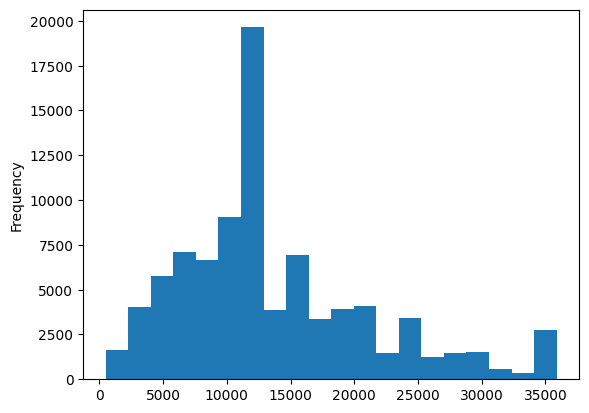

In [214]:
df.loc[df['Current Loan Amount'] < 99999999]['Current Loan Amount'].plot(kind='hist', bins=20)
print(df['Current Loan Amount'].median())

In [215]:
df['Loan Status'][df['Current Loan Amount'].isnull()].value_counts()

,count
Loan Status,


In [216]:
'''#Which of the data fall between lower and upper bound
import numpy as np
import pandas as pd

temp = np.array(df['Current Loan Amount'].values.tolist())
df['Current Loan Amount'] = np.where(temp > 99999998, 12038, temp).tolist()

print(df['Current Loan Amount'][(df['Current Loan Amount'] >= lower) |
(df['Current Loan Amount'] <= upper)].value_counts())...'''

"#Which of the data fall between lower and upper bound\nimport numpy as np\nimport pandas as pd\n\ntemp = np.array(df['Current Loan Amount'].values.tolist())\ndf['Current Loan Amount'] = np.where(temp > 99999998, 12038, temp).tolist()\n\nprint(df['Current Loan Amount'][(df['Current Loan Amount'] >= lower) |\n(df['Current Loan Amount'] <= upper)].value_counts())..."

In [217]:
len(df)

88910

In [218]:
# Performing CP distribution analysis
df['Number of Credit Problems'].value_counts()
# credit problems >=5 can be corrected as 5

,count
Number of Credit Problems,
0,77057
1,10271
2,1092
3,311
4,101
5,46
6,14
7,6
9,4


0


<Axes: xlabel='Term'>

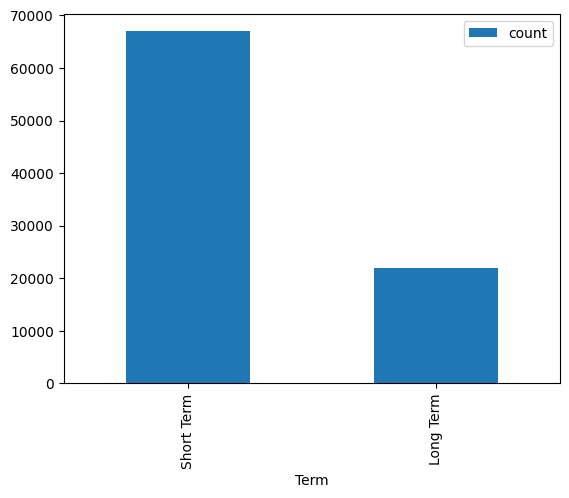

In [219]:
# Distribution of Loan Terms
print(df['Term'].isnull().sum())
df['Term'].value_counts().plot(kind='bar',legend=True)

In [220]:
df.isnull().sum()

,0
Loan ID,0
Customer ID,0
Loan Status,0
Current Loan Amount,0
Term,0
Credit Score,21338
Years in current job,3817
Home Ownership,0
Annual Income,21338
Purpose,0


In [221]:
# Finding invalid credit scores
print(df.shape)
print(df['Credit Score'].value_counts())
print(df['Credit Score'][df['Credit Score']>800].value_counts())
print(df['Credit Score'][df['Credit Score']>800].value_counts().sum())

# There are credit scores beyond 800, which is invalid, however all those appear to be multiples of 800 or below

(88910, 19)
Credit Score
747.0     2040
740.0     1954
746.0     1932
741.0     1922
742.0     1911
          ... 
5860.0       1
5880.0       1
6050.0       1
5890.0       1
5920.0       1
Name: count, Length: 326, dtype: int64
Credit Score
7390.0    118
7370.0    111
7400.0    109
7380.0    103
7330.0     97
         ... 
6050.0      1
5960.0      1
6000.0      1
5900.0      1
5860.0      1
Name: count, Length: 159, dtype: int64
5044


In [222]:
df['Credit Score'].max()

7510.0

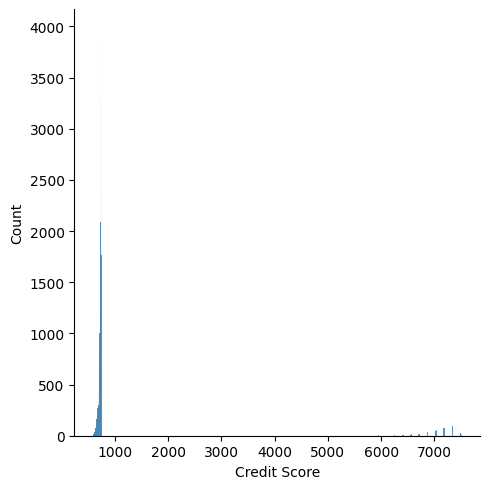

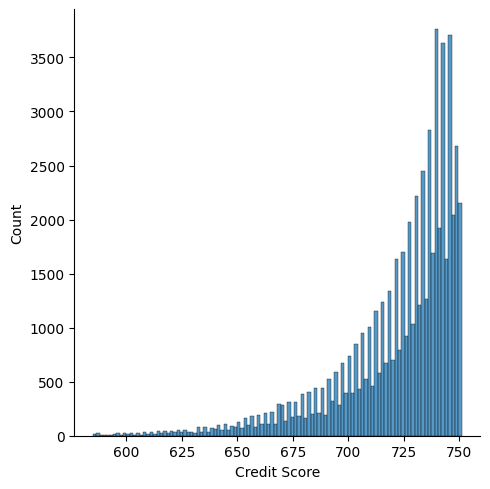

In [223]:
sns.displot(df['Credit Score'])
sns.displot(df[(df['Credit Score']<=800)]['Credit Score'])

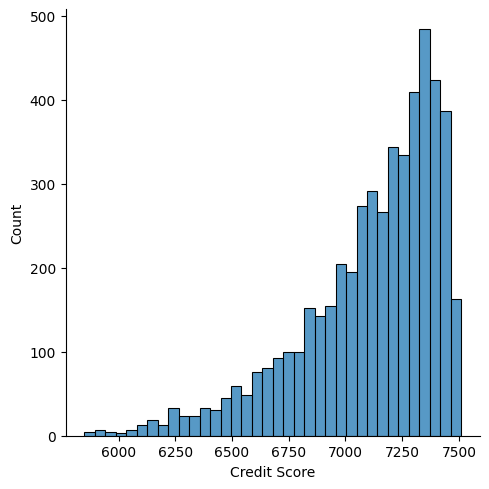

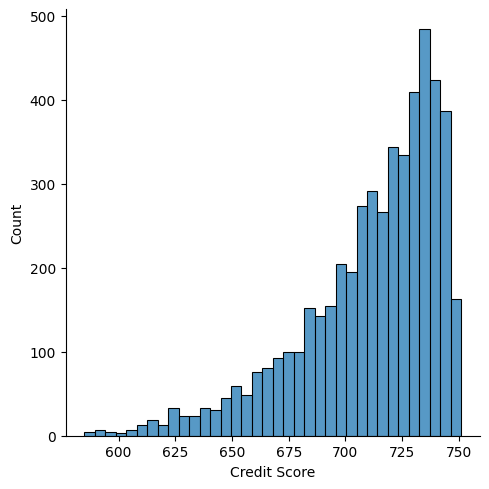

In [224]:
# Can the invalid credit scores be replaced by dividing it by 10
sns.displot(df[(df['Credit Score']>800)]['Credit Score'])
sns.displot(df[(df['Credit Score']>800)]['Credit Score']/10)

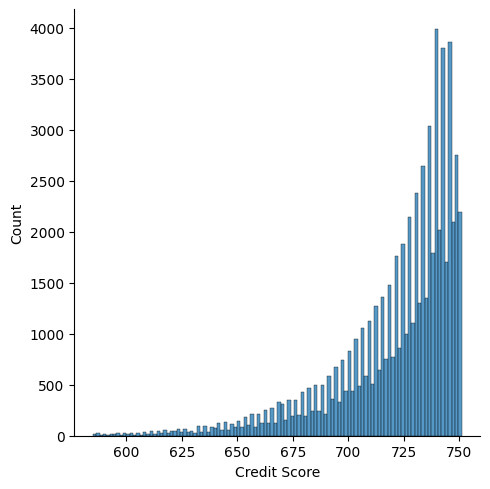

In [225]:
# Replacing all credit values > 800 with values between 0 to 800 by diving it by 10

df["Credit Score"]=np.where(df["Credit Score"]>800, df['Credit Score']/10, df["Credit Score"])
sns.displot(df['Credit Score'])

721.6019505120464 730.0


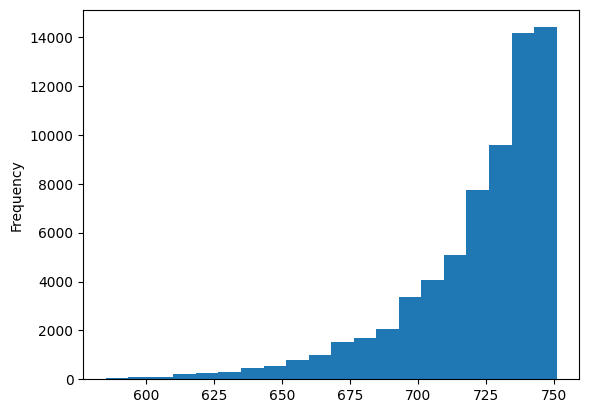

In [226]:
df['Credit Score'].plot(kind='hist', bins=20)
#skewed, so median
print(df['Credit Score'].mean(), df['Credit Score'].median())

In [227]:
df['Credit Score'].isnull().sum()

np.int64(21338)

/tmp/ipython-input-228-1873423852.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Credit Score'].fillna(730, inplace = True)


<Axes: ylabel='Frequency'>

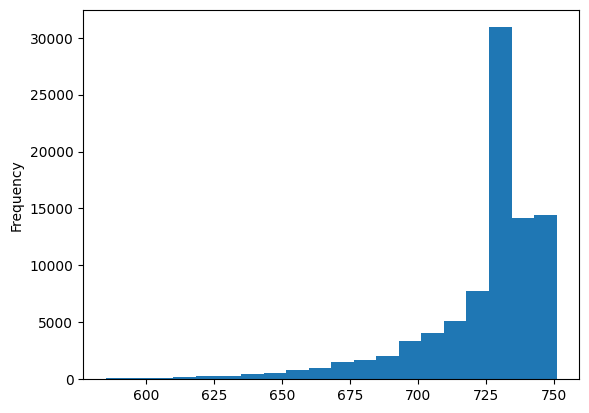

In [228]:
# Can the nulls be replaced with median?
df1=df[['Credit Score']].copy()
df1['Credit Score'].fillna(730, inplace = True)
df1['Credit Score'].plot(kind='hist', bins=20)
# When replaced with median, there is steep peak, which results in distortion, hence let's explore deeper

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88910 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88910 non-null  object 
 1   Customer ID                   88910 non-null  object 
 2   Loan Status                   88910 non-null  object 
 3   Current Loan Amount           88910 non-null  int64  
 4   Term                          88910 non-null  object 
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          85093 non-null  object 
 7   Home Ownership                88910 non-null  object 
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       88910 non-null  object 
 10  Monthly Debt                  88910 non-null  object 
 11  Years of Credit History       88910 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

<Axes: xlabel='Loan Status', ylabel='count'>

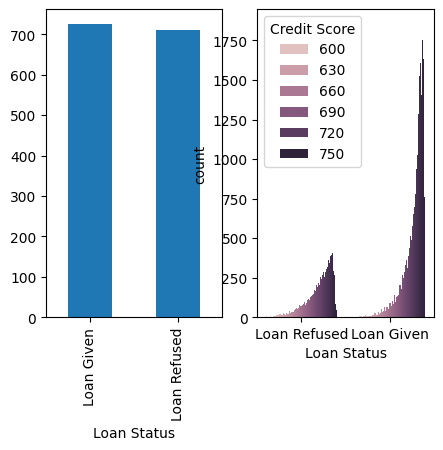

In [230]:
f, ax=plt.subplots(1,2,figsize=(5,4))
df[['Loan Status','Credit Score']].groupby('Loan Status')['Credit Score'].mean().plot.bar(ax=ax[0])
sns.countplot(x='Loan Status',data=df,ax=ax[1], hue='Credit Score')

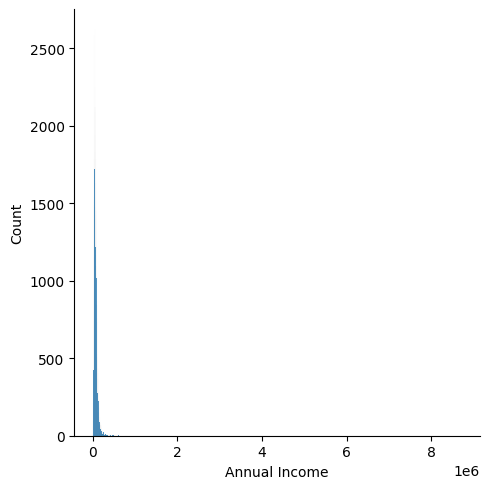

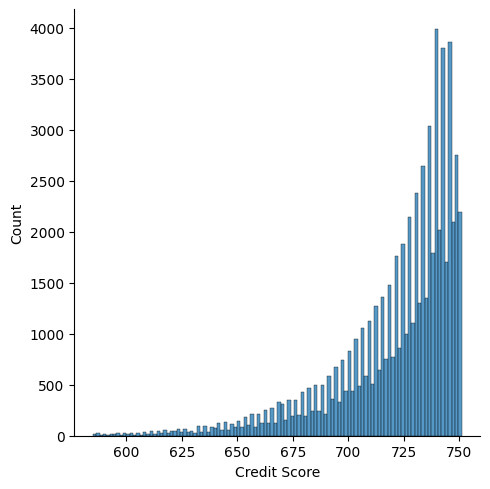

In [231]:
sns.displot(df['Annual Income'])
sns.displot(df['Credit Score'])

In [232]:
# Finding means of Annual Income for different Loan Status

df[['Annual Income', 'Loan Status']].groupby('Loan Status')['Annual Income'].mean()

,Annual Income
Loan Status,
Loan Given,74624.481267
Loan Refused,66574.988395


In [233]:
# Finding counts of home ownership distinct values
df['Home Ownership'].unique()
df['Home Ownership'].value_counts()

,count
Home Ownership,
Home Mortgage,43270
Rent,37395
Own Home,8075
HaveMortgage,170


In [234]:
# HaveMortgage appears to be same as Home Mortgage. Therefore replace them
df['Home Ownership'] = df['Home Ownership'].str.replace('HaveMortgage','Home Mortgage', regex=True)
df['Home Ownership'].value_counts()

,count
Home Ownership,
Home Mortgage,43440
Rent,37395
Own Home,8075


In [235]:
# Finding nulls in Annual Income
print(df['Annual Income'].isna().sum())
df['Annual Income'].isnull().value_counts()

21338


,count
Annual Income,
False,67572
True,21338


In [236]:
# Digging deeper to find if credit score and annual income together with nulls
df[['Credit Score','Annual Income']].isnull().sum()

# Many observations having null for credit score also have null for annual income

,0
Credit Score,21338
Annual Income,21338


In [237]:
# Finding which part of the quartiles have higher incomes
df['Annual Income'].quantile([0.2,0.4,0.6,0.8,.97,.99,.999])
#21, 58, 52, 69, 251

#pd.qcut(df['Annual Income'],5).value_counts()

,Annual Income
0.200,40764.00
0.400,54645.00
0.600,70462.00
0.800,94600.80
0.970,170949.57
0.990,239286.96
0.999,491575.77


In [238]:
df['Annual Income'][df['Annual Income']>239287].value_counts()

,count
Annual Income,
245025.0,3
244416.0,2
402640.0,2
301440.0,2
255600.0,2
...,...
250415.0,1
294090.0,1
270486.0,1


In [239]:
df['Annual Income'].min()

4033.0

In [240]:
df[df['Annual Income']>239287].value_counts().sum()
# There are very few rows (356) with annual income higher than 239287 (99th quartile. Hence, replace those with this value)

np.int64(356)

In [241]:
#capping
df.loc[df['Annual Income']>239287, 'Annual Income'] = 239287

In [242]:
df['Annual Income'].isnull().sum()
# We will hold further to replace nulls

np.int64(21338)

In [243]:
df["Purpose"].value_counts()

,count
Purpose,
Debt Consolidation,70447
Home Improvements,5206
other,4917
Other,2850
Business Loan,1328
Buy a Car,1196
Medical Bills,955
Buy House,559
Take a Trip,454


In [244]:
# Cleaning distinct purpose names
df['Purpose'] = df['Purpose'].str.replace('Other', 'other', regex=True)

In [245]:
# Cleaning $ sign character from monthly debt with reguex
lens=df[df['Monthly Debt'].str.contains(r'\$',na=False)]['Monthly Debt'].str.len()
print(lens)
#df['Monthly Debt'] = df['Monthly Debt'].str.replace('$', '', regex=True)
df['Monthly Debt'] = df['Monthly Debt'].str.replace(r'[\$,]', '', regex=True)

10       8
55       7
105      6
54811    7
54814    8
54822    6
Name: Monthly Debt, dtype: int64


In [246]:
df['Monthly Debt'] = pd.to_numeric(df['Monthly Debt'])

23374
count    65536.000000
mean       962.406632
std        632.799593
min          0.000000
25%        532.250000
50%        843.770000
75%       1251.342500
max      12055.680000
Name: Monthly Debt, dtype: float64


<Axes: ylabel='Monthly Debt'>

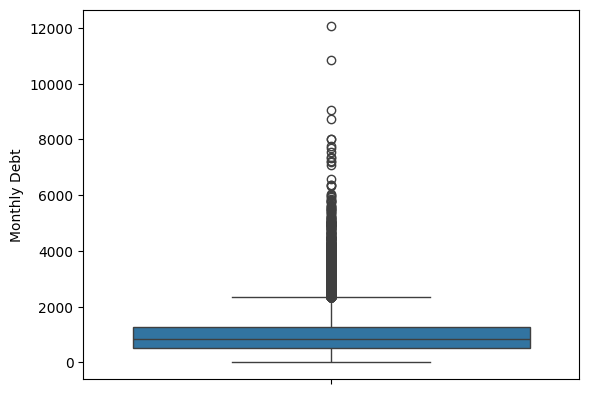

In [247]:
print(df['Monthly Debt'].isnull().sum())
print(df['Monthly Debt'].describe())
sns.boxplot(df['Monthly Debt'])
# This feature appears to have outliers and nulls

In [248]:
#df['Monthly Debt'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
#df['Monthly Debt'].quantile([0.9997, 0.99999])
df['Monthly Debt'].quantile([0.997, 0.999, 1])
#0.999	4927.21625
#1.000	12055.68000

,Monthly Debt
0.997,3880.12120
0.999,4927.21625
1.000,12055.68000


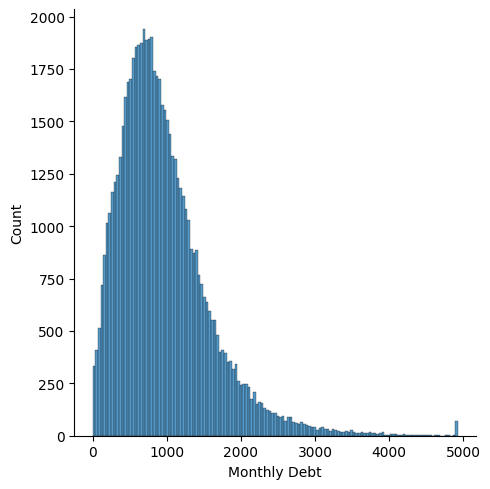

In [249]:
# Capping the values beyond 999th quantile with that value
df.loc[df['Monthly Debt'] > 4927, 'Monthly Debt'] = 4927
sns.displot(df['Monthly Debt'])

In [250]:
print(df['Months since last delinquent'].describe())
print(df['Months since last delinquent'].isnull().sum())

count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64
48506


In [251]:
print(df['Number of Open Accounts'].isnull().sum())
df['Number of Open Accounts'].describe()

0


,Number of Open Accounts
count,88910.000000
mean,11.110348
std,4.978461
min,0.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,76.000000


0.800    15.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64


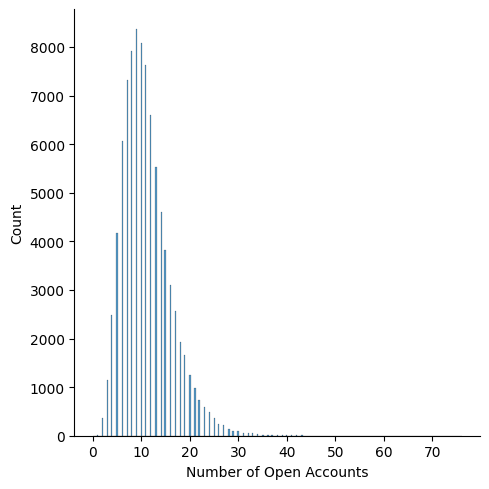

In [252]:
print(df['Number of Open Accounts'].quantile([0.8, 0.999, 1]))
sns.displot(df['Number of Open Accounts'])
# Long right tail

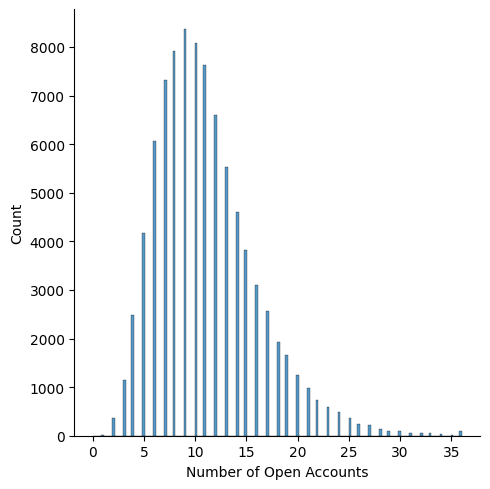

In [253]:
# Capping .999th quantile with that value
df.loc[df['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36
sns.displot(df['Number of Open Accounts'])
# Less lengthier right tail now

In [254]:
'''
# A few bivariate analysis
sns.catplot(y='Credit Score', x='Number of Credit Problems', hue='Loan Status',data=df, kind='point')
sns.catplot(y='Years in current job', x='Number of Credit Problems', hue='Loan Status', data=df, kind='point')
sns.catplot(hue='Loan Status', x='Home Ownership', y='Bankruptcies', data=df, kind='point')
df[df['Number of Credit Problems']>0]['Loan Status'].value_counts()
pd.crosstab(df['Years in current job'], df['Loan Status']).style.background_gradient(cmap='summer_r')
'''

"\n# A few bivariate analysis\nsns.catplot(y='Credit Score', x='Number of Credit Problems', hue='Loan Status',data=df, kind='point')\nsns.catplot(y='Years in current job', x='Number of Credit Problems', hue='Loan Status', data=df, kind='point')\nsns.catplot(hue='Loan Status', x='Home Ownership', y='Bankruptcies', data=df, kind='point')\ndf[df['Number of Credit Problems']>0]['Loan Status'].value_counts()\npd.crosstab(df['Years in current job'], df['Loan Status']).style.background_gradient(cmap='summer_r')\n"

In [255]:
print(df['Number of Credit Problems'].isnull().sum())

df['Number of Credit Problems'].describe()

0


,Number of Credit Problems
count,88910.000000
mean,0.160477
std,0.473746
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,15.000000


In [256]:
print(df['Current Credit Balance'].isnull().sum())
df['Current Credit Balance'].describe()

0


,Current Credit Balance
count,8.891000e+04
mean,1.543593e+04
std,1.965873e+04
min,0.000000e+00
25%,5.949000e+03
50%,1.103900e+04
75%,1.930100e+04
max,1.730472e+06


In [257]:
print(df['Current Credit Balance'].quantile([0.6, 0.75, 0.8, 0.9, 1]))
print(df['Current Credit Balance'].quantile([0.95, 0.96, 0.97, 0.98, 0.99, 1]))
print(df['Current Credit Balance'].quantile([0.98, 0.99, 0.995, 0.999, 1]))
#0.980      57938.120
#0.990      81007.190
#0.995     110219.465
#0.999     227670.033
#1.000    1730472.000

0.60      13693.4
0.75      19301.0
0.80      22034.2
0.90      30843.5
1.00    1730472.0
Name: Current Credit Balance, dtype: float64
0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64
0.980      57938.120
0.990      81007.190
0.995     110219.465
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64


In [258]:
df[df['Current Credit Balance']>81007].value_counts().sum()

np.int64(175)

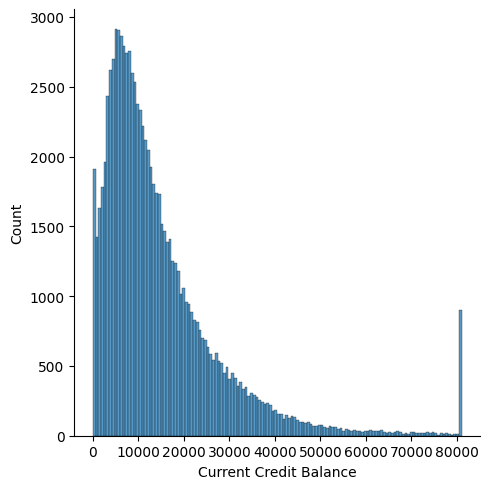

In [259]:
# Capping with .99th quantile value
df.loc[df['Current Credit Balance']>81007, 'Current Credit Balance'] = 81007
sns.displot(df['Current Credit Balance'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


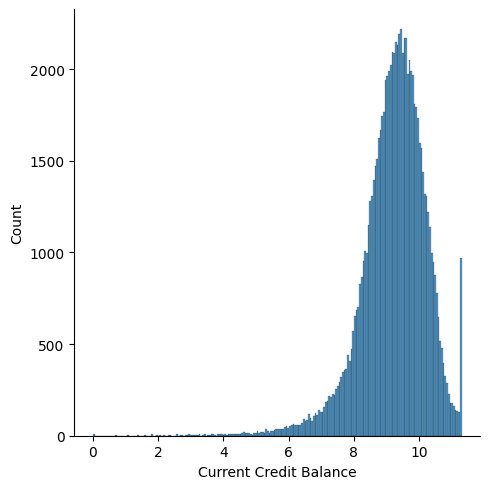

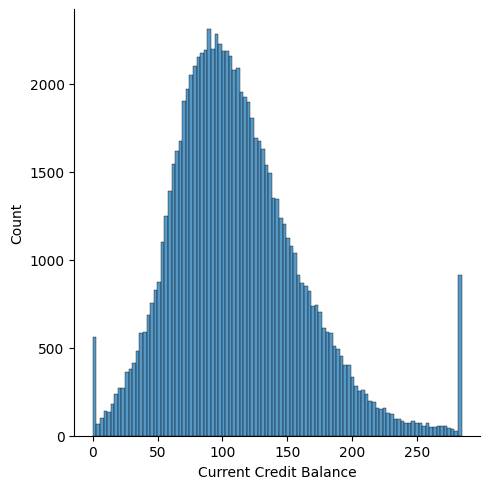

In [260]:
sns.displot(np.log(df['Current Credit Balance']))
sns.displot(np.sqrt(df['Current Credit Balance']))
#sqrt transorm is better than log

In [261]:
# sqrt transformation for current credit balance
df['Current Credit Balance'] = np.sqrt(df['Current Credit Balance'])

In [262]:
print(df['Maximum Open Credit'].isnull().sum())
df['Maximum Open Credit'].describe()

0


,Maximum Open Credit
count,88910
unique,58216
top,0
freq,450


In [263]:
df['Maximum Open Credit'].str.isnumeric().all()

np.False_

In [264]:
df['Maximum Open Credit'].str.contains('#VALUE!').sum()

2

In [265]:
# Cleaning irrelevant characters from maximum open credit
df['Maximum Open Credit']=df['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)
#df.loc[df['Maximum Open Credit'] =="#VALUE!", 'Maximum Open Credit'] = np.nan

In [266]:
df['Maximum Open Credit'] = pd.to_numeric(df['Maximum Open Credit'], errors='coerce')

In [267]:
print(df['Maximum Open Credit'].isnull().sum())
print(df['Maximum Open Credit'].mean())
print(df['Maximum Open Credit'].median())
df['Maximum Open Credit'].quantile([0.8, 0.9, 0.95, 0.99, 1])

2
35965.310174562466
21781.0


,Maximum Open Credit
0.80,41167.00
0.90,56957.50
0.95,76602.40
0.99,171423.93
1.00,69988086.00


In [268]:
# Fill null with mean
df['Maximum Open Credit']=df['Maximum Open Credit'].fillna(35965)

In [269]:
df[df['Maximum Open Credit'] > 171423].value_counts().sum()

np.int64(148)

In [270]:
# Capping with .99th quantile value
df.loc[df['Maximum Open Credit'] > 171423, 'Maximum Open Credit']=171423

In [271]:
print(df['Bankruptcies'].isnull().value_counts())
print(df['Bankruptcies'].describe())
df['Bankruptcies'].value_counts()

Bankruptcies
False    88718
True       192
Name: count, dtype: int64
count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64


,count
Bankruptcies,
0.0,79323
1.0,8936
2.0,353
3.0,80
4.0,19
5.0,5
7.0,1
6.0,1


In [272]:
# Replacing nulls with median
df['Bankruptcies'] = df['Bankruptcies'].fillna(3)

In [273]:
print(df['Tax Liens'].value_counts())
df['Tax Liens'].isnull().value_counts()

Tax Liens
0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: count, dtype: int64


,count
Tax Liens,
False,88902
True,8


In [274]:
# Replacing nulls with median
df['Tax Liens'] = df['Tax Liens'].fillna(5.0)
df['Tax Liens'].isnull().value_counts()

,count
Tax Liens,
False,88910


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88910 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88910 non-null  object 
 1   Customer ID                   88910 non-null  object 
 2   Loan Status                   88910 non-null  object 
 3   Current Loan Amount           88910 non-null  int64  
 4   Term                          88910 non-null  object 
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          85093 non-null  object 
 7   Home Ownership                88910 non-null  object 
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       88910 non-null  object 
 10  Monthly Debt                  65536 non-null  float64
 11  Years of Credit History       88910 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

In [276]:
# Finding if these 3 features with nulls in same observations
r=df[['Credit Score','Annual Income','Months since last delinquent']][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull()]
print(r)
# There are 11619 rows. This should be handled in a right way

# Finding if the 3 are correlated
cor=df[['Credit Score','Annual Income','Months since last delinquent']].corr()
print(cor)
# No notable correlations found

       Credit Score  Annual Income  Months since last delinquent
17782           NaN            NaN                           NaN
17783           NaN            NaN                           NaN
17786           NaN            NaN                           NaN
17787           NaN            NaN                           NaN
17788           NaN            NaN                           NaN
...             ...            ...                           ...
39112           NaN            NaN                           NaN
39113           NaN            NaN                           NaN
39114           NaN            NaN                           NaN
39118           NaN            NaN                           NaN
39119           NaN            NaN                           NaN

[11619 rows x 3 columns]
                              Credit Score  Annual Income  \
Credit Score                      1.000000       0.016781   
Annual Income                     0.016781       1.000000   
Months sinc

In [277]:
# Finding if 2 features with null in same observations and their correlations
r=df[['Months since last delinquent','Monthly Debt']][df['Months since last delinquent'].isnull() & df['Monthly Debt'].isnull()]
print(r)

cor=df[['Months since last delinquent','Monthly Debt']].corr()
print(cor)
# No notable correlations. Will replace nulls later

       Months since last delinquent  Monthly Debt
65537                           NaN           NaN
65538                           NaN           NaN
65539                           NaN           NaN
65540                           NaN           NaN
65541                           NaN           NaN
...                             ...           ...
88897                           NaN           NaN
88900                           NaN           NaN
88902                           NaN           NaN
88904                           NaN           NaN
88909                           NaN           NaN

[12709 rows x 2 columns]
                              Months since last delinquent  Monthly Debt
Months since last delinquent                      1.000000     -0.058363
Monthly Debt                                     -0.058363      1.000000


In [278]:
#print(df['Loan Status'][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & df['Loan Status']].value_counts())

# Target distribution of nulls and non-nulls of the 3 features
print(df['Loan Status'][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & (df['Loan Status']=='Loan Given')].value_counts())
# There is a significant Loan given status with vital 3 features with nulls. This should be handled

# Target distribution of nulls and non-nulls of the 4 features
print(df['Loan Status'][df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & df['Current Loan Amount'].isnull() & df['Loan Status']=='Loan Given'].value_counts())

Loan Status
Loan Given    8339
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


In [279]:
# remove rows will 2 cols null
#cond_to_remove_cols = (df['Credit Score'].isnull() & df['Annual Income'].isnull())

# remove rows with all 3 cols null
#cond_to_remove_cols = (df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull())

# Removing observations with all 3 cols with nulls and loan given
cond_to_remove_cols = (df['Credit Score'].isnull() & df['Annual Income'].isnull() & df['Months since last delinquent'].isnull() & (df['Loan Status']=='Loan Given'))

df = df[~cond_to_remove_cols]

In [280]:
df.shape

(80571, 19)

In [281]:
df.isnull().sum()

,0
Loan ID,0
Customer ID,0
Loan Status,0
Current Loan Amount,0
Term,0
Credit Score,12999
Years in current job,3522
Home Ownership,0
Annual Income,12999
Purpose,0


In [282]:
df['Home Ownership'].value_counts()

,count
Home Ownership,
Home Mortgage,39384
Rent,33869
Own Home,7318


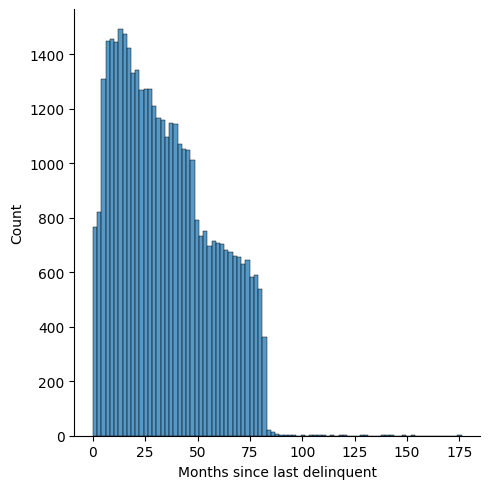

In [283]:
#sns.displot(df['Months since last delinquent'])
sns.displot(df['Months since last delinquent'])

In [284]:
len(df)

80571

In [285]:
# Factorizing categorical features to convert into number
cat_cols = ['Term', 'Years in current job', 'Home Ownership','Purpose']

for col in cat_cols:
  df[col] = pd.factorize(df[col])[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80571 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       80571 non-null  object 
 1   Customer ID                   80571 non-null  object 
 2   Loan Status                   80571 non-null  object 
 3   Current Loan Amount           80571 non-null  int64  
 4   Term                          80571 non-null  int64  
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          80571 non-null  int64  
 7   Home Ownership                80571 non-null  int64  
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       80571 non-null  int64  
 10  Monthly Debt                  57197 non-null  float64
 11  Years of Credit History       80571 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

In [286]:
#Binarize the target variable
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
df['Loan Status'] = df['Loan Status'].astype(str)
y = lb.fit_transform(df['Loan Status'])
y = y.ravel()
#np.bincount(y)

In [287]:
y

array([1, 1, 1, ..., 0, 1, 0])

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80571 entries, 0 to 88909
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       80571 non-null  object 
 1   Customer ID                   80571 non-null  object 
 2   Loan Status                   80571 non-null  object 
 3   Current Loan Amount           80571 non-null  int64  
 4   Term                          80571 non-null  int64  
 5   Credit Score                  67572 non-null  float64
 6   Years in current job          80571 non-null  int64  
 7   Home Ownership                80571 non-null  int64  
 8   Annual Income                 67572 non-null  float64
 9   Purpose                       80571 non-null  int64  
 10  Monthly Debt                  57197 non-null  float64
 11  Years of Credit History       80571 non-null  float64
 12  Months since last delinquent  40404 non-null  float64
 13  Number

In [289]:
cols = df.columns[3:19]
X_scaled = preprocessing.scale(df[cols])
X_scaled = pd.DataFrame(X_scaled, columns=cols)

In [290]:
X_scaled.isnull().sum()

,0
Current Loan Amount,0
Term,0
Credit Score,12999
Years in current job,0
Home Ownership,0
Annual Income,12999
Purpose,0
Monthly Debt,23374
Years of Credit History,0
Months since last delinquent,40167


<Axes: ylabel='Frequency'>

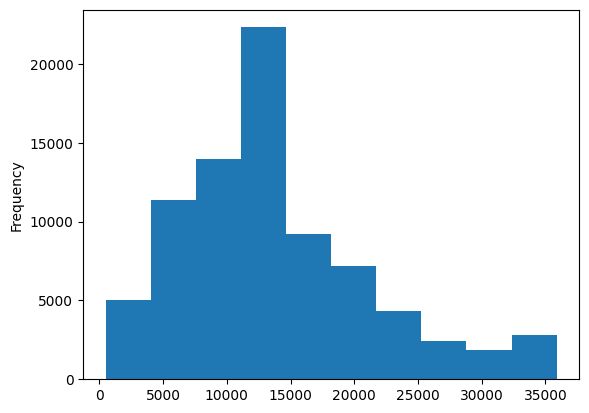

In [291]:
df['Current Loan Amount'].plot(kind='hist')

In [292]:
'''from sklearn.impute import KNNImputer

# Create KNN imputer instance (you can tune n_neighbors)
imputer = KNNImputer(n_neighbors=11)
_2cols = ['Months since last delinquent']
# Apply imputation
df_2cols = imputer.fit_transform(X_scaled[_2cols])
df_2cols = pd.DataFrame(df_2cols, columns=_2cols)'''


"from sklearn.impute import KNNImputer\n\n# Create KNN imputer instance (you can tune n_neighbors)\nimputer = KNNImputer(n_neighbors=11)\n_2cols = ['Months since last delinquent']\n# Apply imputation\ndf_2cols = imputer.fit_transform(X_scaled[_2cols])\ndf_2cols = pd.DataFrame(df_2cols, columns=_2cols)"

In [293]:
corr_matrix = df[df.columns[3:19]].corr()
print(corr_matrix['Current Loan Amount'].sort_values(ascending=False))
print(corr_matrix['Annual Income'].sort_values(ascending=False))
print(corr_matrix['Monthly Debt'].sort_values(ascending=False))

Current Loan Amount             1.000000
Annual Income                   0.424402
Current Credit Balance          0.400379
Term                            0.388052
Monthly Debt                    0.387920
Maximum Open Credit             0.318223
Number of Open Accounts         0.182436
Years of Credit History         0.134142
Home Ownership                  0.111633
Tax Liens                       0.020384
Years in current job           -0.022379
Months since last delinquent   -0.036935
Number of Credit Problems      -0.063602
Bankruptcies                   -0.093179
Purpose                        -0.136270
Credit Score                   -0.214080
Name: Current Loan Amount, dtype: float64
Annual Income                   1.000000
Monthly Debt                    0.610933
Current Loan Amount             0.424402
Current Credit Balance          0.393230
Maximum Open Credit             0.388785
Years of Credit History         0.211644
Number of Open Accounts         0.198767
Home Ownership 

In [294]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

_cols = ['Current Loan Amount','Annual Income','Monthly Debt','Current Credit Balance','Term','Maximum Open Credit']
imputer = IterativeImputer()
df_col = imputer.fit_transform(X_scaled[_cols])
df_col = pd.DataFrame(df_col, columns=_cols)
X_scaled[_cols]=df_col

In [295]:
X_scaled.isnull().sum()

,0
Current Loan Amount,0
Term,0
Credit Score,12999
Years in current job,0
Home Ownership,0
Annual Income,0
Purpose,0
Monthly Debt,0
Years of Credit History,0
Months since last delinquent,40167


In [296]:
'''updated_df = X_scaled.copy()
updated_df[['Months since last delinquent']] = df_2cols
updated_df[['Monthly Debt']] = df_col
updated_df.isnull().sum()'''

"updated_df = X_scaled.copy()\nupdated_df[['Months since last delinquent']] = df_2cols\nupdated_df[['Monthly Debt']] = df_col\nupdated_df.isnull().sum()"

In [297]:
updated_df = X_scaled.copy()

In [298]:
!pip install fancyimpute
from fancyimpute import KNN, SoftImpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.5 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=76aea29995326143e48b3be91f22ec9e11462acc8784d1a13548f5cd24724ff0
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=d5f7cb76cc9cabf3e696644165381c5565f7eebd398dac2ee112f6f46f11e90b
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute


In [299]:
updated_df = pd.DataFrame(data=SoftImpute().fit_transform(df[df.columns[3:19]]), columns = df[df.columns[3:19]].columns, index=df.index)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[SoftImpute] Max Singular Value of X_init = 23023196.340466
[SoftImpute] Iter 1: observed MAE=271.372237 rank=3
[SoftImpute] Iter 2: observed MAE=267.736954 rank=3
[SoftImpute] Iter 3: observed MAE=267.237544 rank=3
[SoftImpute] Iter 4: observed MAE=267.172492 rank=3
[SoftImpute] Iter 5: observed MAE=267.179722 rank=3
[SoftImpute] Iter 6: observed MAE=267.202650 rank=3
[SoftImpute] Iter 7: observed MAE=267.228944 rank=3
[SoftImpute] Iter 8: observed MAE=267.255290 rank=3
[SoftImpute] Iter 9: observed MAE=267.280621 rank=3
[SoftImpute] Iter 10: observed MAE=267.304518 rank=3
[SoftImpute] Iter 11: observed MAE=267.326836 rank=3
[SoftImpute] Iter 12: observed MAE=267.347585 rank=3
[SoftImpute] Iter 13: observed MAE=267.366759 rank=3
[SoftImpute] Iter 14: observed MAE=267.384382 rank=3
[SoftImpute] Iter 15: observed MAE=267.400468 rank=3
[SoftImpute] Iter 16: observed MAE=267.415157 rank=3
[SoftImpute] Iter 17: observed MAE=267.428516 rank=3
[SoftImpute] Iter 18: observed MAE=267.440570 ra

In [300]:
#df_LC = pd.get_dummies(updated_df, drop_first=True)
#df_LC.info()

In [301]:
'''#Binarize the target variable
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
df['Loan Status'] = df['Loan Status'].astype(str)
y = lb.fit_transform(df['Loan Status'])
y = y.ravel()
#np.bincount(y)'''

"#Binarize the target variable\nfrom sklearn import preprocessing\nlb = preprocessing.LabelBinarizer()\ndf['Loan Status'] = df['Loan Status'].astype(str)\ny = lb.fit_transform(df['Loan Status'])\ny = y.ravel()\n#np.bincount(y)"

In [302]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80571 entries, 0 to 88909
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount           80571 non-null  float64
 1   Term                          80571 non-null  float64
 2   Credit Score                  80571 non-null  float64
 3   Years in current job          80571 non-null  float64
 4   Home Ownership                80571 non-null  float64
 5   Annual Income                 80571 non-null  float64
 6   Purpose                       80571 non-null  float64
 7   Monthly Debt                  80571 non-null  float64
 8   Years of Credit History       80571 non-null  float64
 9   Months since last delinquent  80571 non-null  float64
 10  Number of Open Accounts       80571 non-null  float64
 11  Number of Credit Problems     80571 non-null  float64
 12  Current Credit Balance        80571 non-null  float64
 13  Maximu

In [303]:
'''#Scaling independent variables
X_scaled = preprocessing.scale(df_LC)
type(X_scaled)'''

'#Scaling independent variables\nX_scaled = preprocessing.scale(df_LC)\ntype(X_scaled)'

In [304]:

def feat_importance(estimator):
  feature_importance = {}
  for index, name in enumerate(updated_df.columns):#_LC.columns):
    feature_importance[name] = estimator.feature_importances_[index]
  feature_importance = {k: v for k, v in feature_importance.items()}
  sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
  return sorted_x

In [305]:
def classify(est, x, y, X_test, y_test):
  est.fit(x,y)
  y1 = est.predict(X_test)
  y2 = est.predict_proba(X_test)
  return est, y1, y2[:,1]

In [306]:

def plot_roc_curve(model, yy_test, p_prob):
  fpr2, tpr2, thresh2 = roc_curve(yy_test, p_prob, pos_label=1)

  print(f" Area UC: {metrics.auc(fpr2, tpr2)}")
  plt.plot(fpr2, tpr2, linestyle='--',color='red', label=model.__class__.__name__)

  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()

In [307]:
def print_metrics(model, y_test, y_pred):
  print(f"Accuracy: {accuracy_score(y_test, y_pred)} \n Precision: {precision_score(y_test, y_pred)} \n Recall: {recall_score(y_test, y_pred)} \n f1-score: {f1_score(y_test, y_pred)} \n")
  print(f"Confusion matrix: {confusion_matrix(y_test, y_pred)}")
  print(f"Classification report: {classification_report(y_test, y_pred)}")
  print(f"Mathews Correlation: {matthews_corrcoef(y_test, y_pred)}")

In [308]:
#Current Loan Amount, Term, Credit Score, Annual Income, Monthly Debt, Number of Open Accounts, Current Credit Balance, Maximum Open Account, Bankruptcies, Tax Liens

In [309]:
X_train, X_test, y_train, y_test = train_test_split(updated_df, y, test_size=0.2, stratify=y, random_state=3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64456, 16) (16115, 16) (64456,) (16115,)


[0.19019488 0.16636227 0.16821563 0.02965208 0.05945471 0.04950667
 0.03284223 0.03093684 0.03249082 0.05436702 0.02791948 0.02739249
 0.03212446 0.03224974 0.02752502 0.03876562]


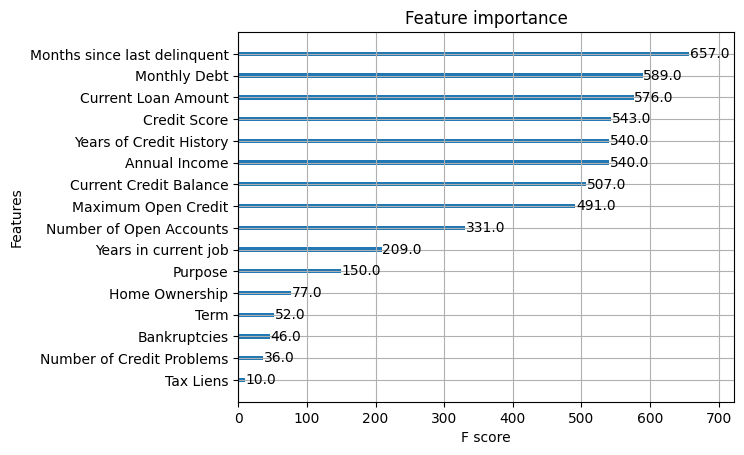

In [310]:
feature_names=updated_df.columns
# Finding importance of features
xgb, y_pred, y_prob = classify(XGBClassifier(), X_train, y_train, X_test, y_test)

print(xgb.feature_importances_)
plot_importance(xgb)
pyplot.show()
#feat1 = feat_importance(xgb)
#xgb.get_booster().get_score(importance_type='weight')

Accuracy: 0.730251318647223 
 Precision: 0.6027479091995221 
 Recall: 0.40079443892750743 
 f1-score: 0.48145055469402365 

Confusion matrix: [[9750 1330]
 [3017 2018]]
Classification report:               precision    recall  f1-score   support

           0       0.76      0.88      0.82     11080
           1       0.60      0.40      0.48      5035

    accuracy                           0.73     16115
   macro avg       0.68      0.64      0.65     16115
weighted avg       0.71      0.73      0.71     16115

Mathews Correlation: 0.32074886363622557
 Area UC: 0.7711192321618705


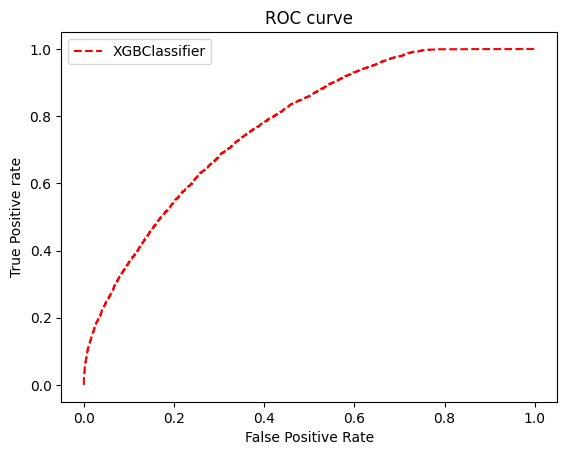

In [311]:
xgb, y_pred, y_prob = classify(XGBClassifier(n_estimators=360, learning_rate=0.01, max_depth=27, min_child_weight=2), X_train, y_train, X_test, y_test)

print_metrics(xgb, y_test, y_pred)
plot_roc_curve(xgb, y_test, y_prob)

 xgb - before oversampling - after removing credit score and annual income null for loan given
 * Accuracy: 0.730251318647223
 * Precision: 0.6027479091995221
 * Recall: 0.40079443892750743
 * f1-score: 0.48145055469402365
 * Mathews Correlation: 0.32074886363622557
 * Area UC: 0.7711192321618705

xgb - Before oversampling, After removing all credit score & annual income nulls for loan given & current loan amount 99999999 to null, Iterative imputing with ['Current Loan Amount','Annual Income','Monthly Debt','Current Credit Balance','Term','Maximum Open Credit']
* Accuracy: 0.7287620229599752
* Precision: 0.6120107962213225
* Recall: 0.3602780536246276
* f1-score: 0.45355669458682335
* Mathews Correlation: 0.3068437147630159
* Area UC: 0.7335637720074999

Accuracy: 0.6811666149550109 
 Precision: 0.4780383795309168 
 Recall: 0.22264150943396227 
 f1-score: 0.3037940379403794 

Confusion matrix: [[9856 1224]
 [3914 1121]]
Classification report:               precision    recall  f1-score   support

           0       0.72      0.89      0.79     11080
           1       0.48      0.22      0.30      5035

    accuracy                           0.68     16115
   macro avg       0.60      0.56      0.55     16115
weighted avg       0.64      0.68      0.64     16115

Mathews Correlation: 0.14744038072039675
 Area UC: 0.6637400471070736


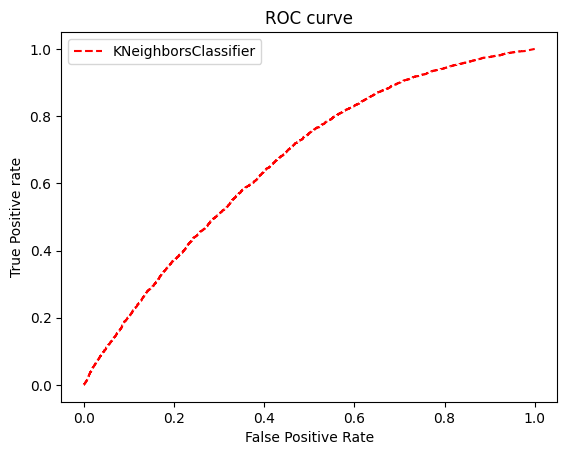

In [312]:
knn, y_pred, y_prob = classify(KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='auto', metric='euclidean'), X_train, y_train, X_test, y_test)

print_metrics(knn, y_test, y_pred)
plot_roc_curve(knn, y_test, y_prob)

Accuracy: 0.6326403971455166 
 Precision: 0.4306535025858016 
 Recall: 0.5457795431976167 
 f1-score: 0.48142957252978275 

Confusion matrix: [[7447 3633]
 [2287 2748]]
Classification report:               precision    recall  f1-score   support

           0       0.77      0.67      0.72     11080
           1       0.43      0.55      0.48      5035

    accuracy                           0.63     16115
   macro avg       0.60      0.61      0.60     16115
weighted avg       0.66      0.63      0.64     16115

Mathews Correlation: 0.20649986707123474
 Area UC: 0.6280303578918689


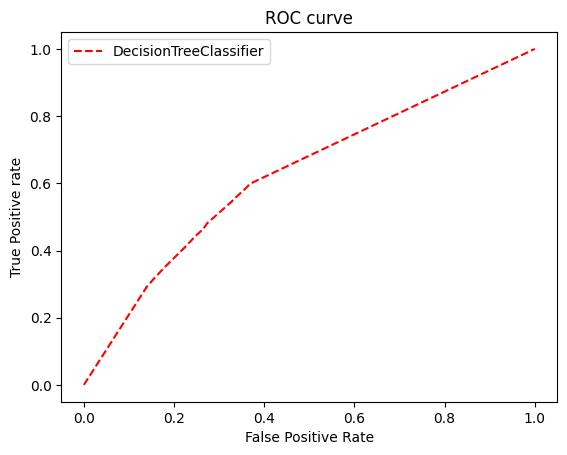

In [313]:
dt, y_pred, y_prob = classify(DecisionTreeClassifier(max_depth=180, min_samples_split=3, min_samples_leaf=3, max_features='log2', criterion='log_loss',class_weight='balanced',random_state=3), X_train, y_train, X_test, y_test)

print_metrics(dt, y_test, y_pred)
plot_roc_curve(dt, y_test, y_prob)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Accuracy: 0.6178094942600062 
 Precision: 0.4189033189033189 
 Recall: 0.5765640516385303 
 f1-score: 0.485248641872127 

Confusion matrix: [[7053 4027]
 [2132 2903]]
Classification report:               precision    recall  f1-score   support

           0       0.77      0.64      0.70     11080
           1       0.42      0.58      0.49      5035

    accuracy                           0.62     16115
   macro avg       0.59      0.61      0.59     16115
weighted avg       0.66      0.62      0.63     16115

Mathews Correlation: 0.19951717537383812
 Area UC: 0.6464189123786921


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


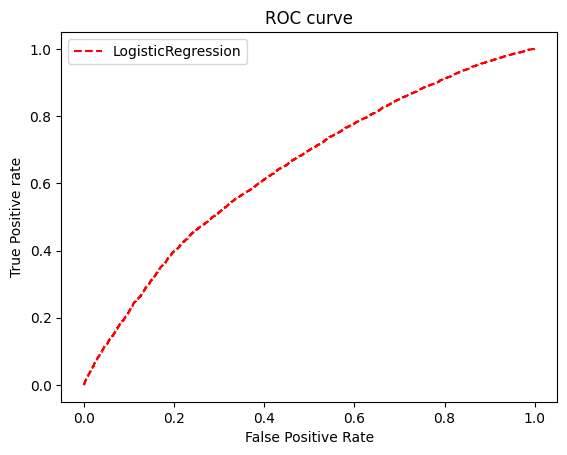

In [314]:
lr, y_pred, y_prob = classify(LogisticRegression(solver='saga', class_weight='balanced', penalty='l2', l1_ratio=.2, fit_intercept=False, random_state=3), X_train, y_train, X_test, y_test)

print_metrics(lr, y_test, y_pred)
plot_roc_curve(lr, y_test, y_prob)

Accuracy: 0.7265280794291034 
 Precision: 0.5574880995972171 
 Recall: 0.6047666335650447 
 f1-score: 0.5801657616461846 

Confusion matrix: [[8663 2417]
 [1990 3045]]
Classification report:               precision    recall  f1-score   support

           0       0.81      0.78      0.80     11080
           1       0.56      0.60      0.58      5035

    accuracy                           0.73     16115
   macro avg       0.69      0.69      0.69     16115
weighted avg       0.73      0.73      0.73     16115

Mathews Correlation: 0.37857216789430725
 Area UC: 0.7836732583109569


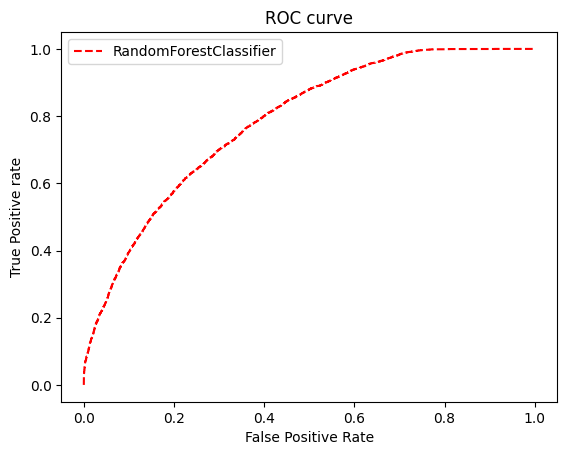

In [315]:
rf, y_pred, y_prob = classify(RandomForestClassifier(n_estimators=256,criterion='log_loss', min_samples_split=9, min_samples_leaf=7, max_features='sqrt',max_depth=64, class_weight='balanced',random_state=3), X_train, y_train, X_test, y_test)

print_metrics(rf, y_test, y_pred)
plot_roc_curve(rf, y_test, y_prob)

random forest - Before oversampling, After removing all credit score & annual income nulls:
 * Accuracy: 0.7196448390677026
 * Precision: 0.5041322314049587
 * Recall: 0.5899111343439624
 * f1-score: 0.543658918463206
 * Mathews Correlation: 0.34532745279760185
 * Area UC: 0.7779471085521884

random forest - Before oversampling, After removing all credit score & annual income null for loan given:
* Accuracy: 0.7265280794291034
* Precision: 0.5574880995972171
* Recall: 0.6047666335650447
* f1-score: 0.5801657616461846
* Mathews Correlation: 0.37857216789430725
* Area UC: 0.7836732583109569

random forest - Before oversampling, After removing all credit score & annual income null for loan given & current loan amount 99999999 to null
* Accuracy: 0.7281414830902886
* Precision: 0.5718365553602812
* Recall: 0.5169811320754717
* f1-score: 0.5430270157504955
* Mathews Correlation: 0.35114598429589267
* Area UC: 0.7457901010615224

In [316]:
'''from sklearn.model_selection import cross_val_score, KFold
knn = KNeighborsClassifier(n_neighbors=25)
# YOUR CODE HERE : call kfold cross validation
kf=KFold(n_splits=7)
score = cross_val_score(knn,X_train, y_train, cv=kf) # YOUR CODE HERE : Compute the Cross Validation score using the imported function "cross_val_score"
print(score)
print(np.mean(score))'''

'from sklearn.model_selection import cross_val_score, KFold\nknn = KNeighborsClassifier(n_neighbors=25)\n# YOUR CODE HERE : call kfold cross validation\nkf=KFold(n_splits=7)\nscore = cross_val_score(knn,X_train, y_train, cv=kf) # YOUR CODE HERE : Compute the Cross Validation score using the imported function "cross_val_score"\nprint(score)\nprint(np.mean(score))'

In [317]:
'''
from sklearn.model_selection import GridSearchCV

k_range = list(range(1, 31))
print(k_range)

# Mention all the parameters that we want to iterate across
param_grid = dict(n_neighbors=k_range) # YOUR CODE HERE
print(param_grid)

grid = GridSearchCV(knn, param_grid, scoring='accuracy', cv=10, return_train_score=False)
grid.fit(X_train, y_train)

grid_mean_score = grid.cv_results_['mean_test_score']
print(grid_mean_score)

plt.plot(k_range,grid_mean_score)
plt.xlabel('k for Knn')
plt.ylabel('accuracy - cv')
'''

"\nfrom sklearn.model_selection import GridSearchCV\n\nk_range = list(range(1, 31))\nprint(k_range)\n\n# Mention all the parameters that we want to iterate across\nparam_grid = dict(n_neighbors=k_range) # YOUR CODE HERE\nprint(param_grid)\n\ngrid = GridSearchCV(knn, param_grid, scoring='accuracy', cv=10, return_train_score=False)\ngrid.fit(X_train, y_train)\n\ngrid_mean_score = grid.cv_results_['mean_test_score']\nprint(grid_mean_score)\n\nplt.plot(k_range,grid_mean_score)\nplt.xlabel('k for Knn')\nplt.ylabel('accuracy - cv')\n"

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
[0.70921637 0.76059042 0.73040922 0.76059042 0.7451098  0.76335053
 0.75454218 0.76539062 0.76020641 0.76797072 0.76432257 0.76895476
 0.76555862 0.76960278 0.76763471 0.77062282 0.76920677 0.77130685
 0.7699748  0.77101884 0.77043082 0.77149886 0.77081483 0.77190688
 0.77140286 0.77193088 0.77167887 0.7724349  0.77232689 0.7724709 ]
Text(0, 0.5, 'accuracy - cv')

Best Estimator, Best parameters & Best sore:  KNeighborsClassifier(n_neighbors=30) {'n_neighbors': 30} 0.7724708988359535

In [318]:
'''# YOUR CODE HERE : print the best score, params, estimator
print("Best Estimator, Best parameters & Best sore: ",grid.best_estimator_, grid.best_params_, grid.best_score_)'''

'# YOUR CODE HERE : print the best score, params, estimator\nprint("Best Estimator, Best parameters & Best sore: ",grid.best_estimator_, grid.best_params_, grid.best_score_)'

In [319]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(64456, 16) (64456,) (16115, 16) (16115,)


In [320]:
updated_df.columns.tolist()

['Current Loan Amount',
 'Term',
 'Credit Score',
 'Years in current job',
 'Home Ownership',
 'Annual Income',
 'Purpose',
 'Monthly Debt',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Bankruptcies',
 'Tax Liens']

In [321]:
#index_split = int(0.95*len(X_scaled))
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(updated_df, y, test_size=0.05, stratify=y, random_state=3)

print(X_train_smote.shape, y_train_smote.shape, X_test_smote.shape, y_test_smote.shape)

(76542, 16) (76542,) (4029, 16) (4029,)


In [322]:
print(np.unique(y_train_smote, return_counts=True))
print(np.unique(y_test_smote, return_counts=True))

(array([0, 1]), array([52628, 23914]))
(array([0, 1]), array([2770, 1259]))


In [323]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

print(X_train_smote.shape, y_train_smote.shape, X_test_smote.shape, y_test_smote.shape)

(105256, 16) (105256,) (4029, 16) (4029,)


In [324]:
print(np.unique(y_train_smote, return_counts=True))
print(np.unique(y_test_smote, return_counts=True))

(array([0, 1]), array([52628, 52628]))
(array([0, 1]), array([2770, 1259]))


In [325]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([44318, 20138]))
(array([0, 1]), array([11080,  5035]))


Accuracy: 0.5999007197815835 
 Precision: 0.40586666666666665 
 Recall: 0.6044479745830024 
 f1-score: 0.4856413529036375 

Confusion matrix: [[1656 1114]
 [ 498  761]]
Classification report:               precision    recall  f1-score   support

           0       0.77      0.60      0.67      2770
           1       0.41      0.60      0.49      1259

    accuracy                           0.60      4029
   macro avg       0.59      0.60      0.58      4029
weighted avg       0.66      0.60      0.61      4029

Mathews Correlation: 0.18796903373819446
 Area UC: 0.6405069062318096


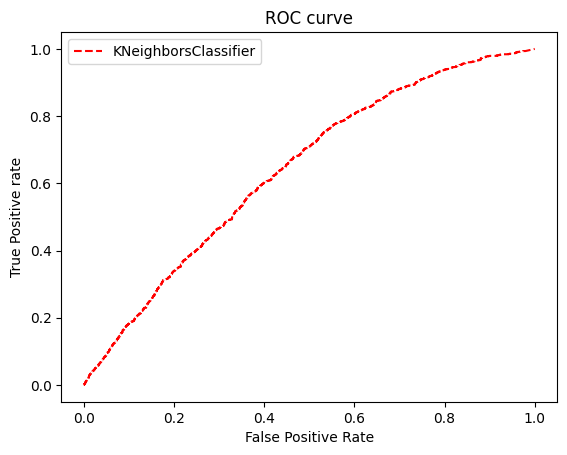

In [326]:
knn, y_pred, y_prob = classify(KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='auto', metric='euclidean'), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(knn, y_test_smote, y_pred)
plot_roc_curve(knn, y_test_smote, y_prob)

Accuracy: 0.6656738644825019 
 Precision: 0.46496815286624205 
 Recall: 0.46386020651310567 
 f1-score: 0.4644135188866799 

Confusion matrix: [[2098  672]
 [ 675  584]]
Classification report:               precision    recall  f1-score   support

           0       0.76      0.76      0.76      2770
           1       0.46      0.46      0.46      1259

    accuracy                           0.67      4029
   macro avg       0.61      0.61      0.61      4029
weighted avg       0.67      0.67      0.67      4029

Mathews Correlation: 0.22140515363028002
 Area UC: 0.6401169342467089


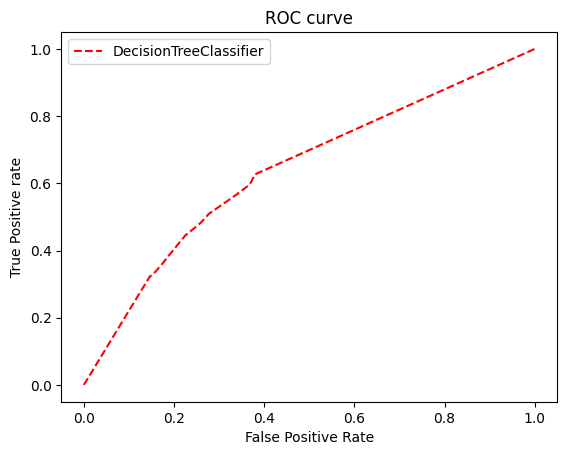

In [327]:
dt, y_pred, y_prob = classify(DecisionTreeClassifier(max_depth=60, min_samples_split=3, min_samples_leaf=3, max_features='log2', criterion='log_loss',class_weight='balanced',random_state=3), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(dt, y_test_smote, y_pred)
plot_roc_curve(dt, y_test_smote, y_prob)

Accuracy: 0.6118143459915611 
 Precision: 0.4125071715433161 
 Recall: 0.5710881652104846 
 f1-score: 0.47901399067288475 

Confusion matrix: [[1746 1024]
 [ 540  719]]
Classification report:               precision    recall  f1-score   support

           0       0.76      0.63      0.69      2770
           1       0.41      0.57      0.48      1259

    accuracy                           0.61      4029
   macro avg       0.59      0.60      0.58      4029
weighted avg       0.65      0.61      0.62      4029

Mathews Correlation: 0.18843154231806566
 Area UC: 0.6469041672521025


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


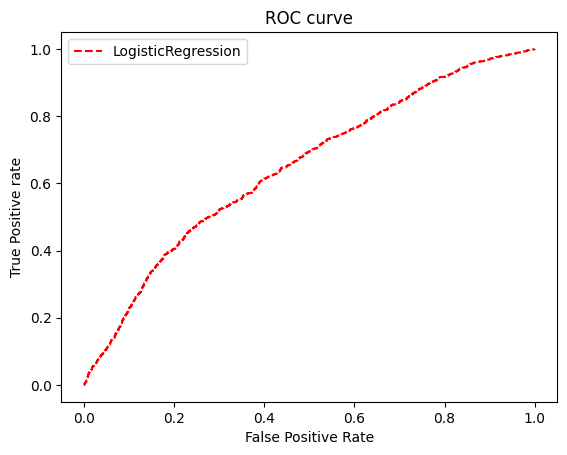

In [328]:
lr, y_pred, y_prob = classify(LogisticRegression(solver='saga', class_weight='balanced', penalty='elasticnet', l1_ratio=.9,fit_intercept=False, random_state=3), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(lr, y_test_smote, y_pred)
plot_roc_curve(lr, y_test_smote, y_prob)

Accuracy: 0.7443534375775627 
 Precision: 0.6141575274177468 
 Recall: 0.4892772041302621 
 f1-score: 0.5446507515473032 

Confusion matrix: [[2383  387]
 [ 643  616]]
Classification report:               precision    recall  f1-score   support

           0       0.79      0.86      0.82      2770
           1       0.61      0.49      0.54      1259

    accuracy                           0.74      4029
   macro avg       0.70      0.67      0.68      4029
weighted avg       0.73      0.74      0.74      4029

Mathews Correlation: 0.3747115002090581
 Area UC: 0.7806097900172906


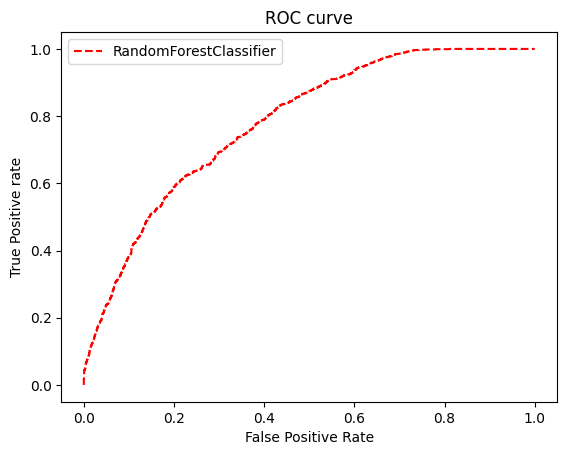

In [329]:
rf, y_pred, y_prob = classify(RandomForestClassifier(n_estimators=256,criterion='log_loss', min_samples_split=9, min_samples_leaf=7, max_features='sqrt',max_depth=31, class_weight='balanced',random_state=3), X_train_smote, y_train_smote, X_test_smote, y_test_smote)

print_metrics(rf, y_test_smote, y_pred)
plot_roc_curve(rf, y_test_smote, y_prob)

#RandomForestClassifier(n_estimators=164,criterion='log_loss', #min_samples_split=3, min_samples_leaf=2, max_features='sqrt',max_depth=31, #class_weight='balanced',random_state=3)

random forest - After oversampling, After removing all credit score & annual income nulls:
*  Accuracy: 0.7372003551346552
*  Precision: 0.54521625163827
*  Recall: 0.4346917450365726
*  f1-score: 0.48372093023255813
*  Mathews Correlation: 0.31403916720771263
*  Area UC: 0.7820919695545966

random forest - After oversampling, After removing all credit score & annual income nulls for loan given:
* Accuracy: 0.741126830479027
* Precision: 0.6067193675889329
* Recall: 0.48768864177918986
* f1-score: 0.5407309555261999
* Mathews Correlation: 0.36765567495757817
* Area UC: 0.7795029577654604

random forest - After oversampling, After removing all credit score & annual income nulls for loan given & current loan amount 99999999 to null
* Accuracy: 0.7359146190121618
* Precision: 0.6121979286536249
* Recall: 0.42255758538522636
* f1-score: 0.5
* Mathews Correlation: 0.33909164159796096
* Area UC: 0.7344697958095217

random forest - After oversampling, After removing all credit score & annual income nulls for loan given & current loan amount 99999999 to null, Iterative imputing with ['Current Loan Amount','Annual Income','Monthly Debt','Current Credit Balance','Term','Maximum Open Credit']

* Accuracy: 0.7379002233804914
* Precision: 0.6154721274175199
* Recall: 0.42970611596505165
* f1-score: 0.5060804490177736
* Mathews Correlation: 0.3453095509760282
* Area UC: 0.7341690012416019

Accuracy: 0.718788781335319 
 Precision: 0.5426829268292683 
 Recall: 0.636219221604448 
 f1-score: 0.5857404021937843 

Confusion matrix: [[2095  675]
 [ 458  801]]
Classification report:               precision    recall  f1-score   support

           0       0.82      0.76      0.79      2770
           1       0.54      0.64      0.59      1259

    accuracy                           0.72      4029
   macro avg       0.68      0.70      0.69      4029
weighted avg       0.73      0.72      0.72      4029

Mathews Correlation: 0.37762841359988286
 Area UC: 0.7806097900172906


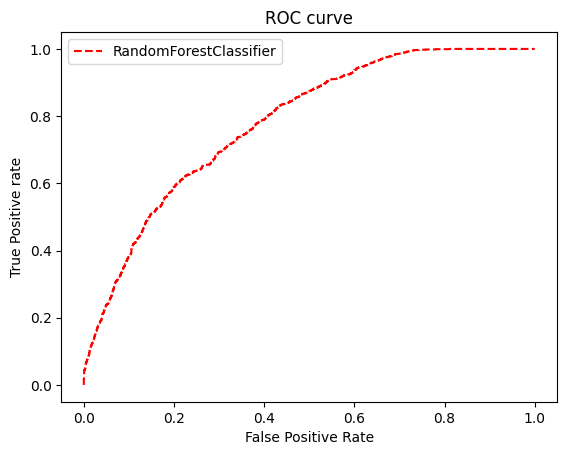

In [330]:
y_pred_thresh = (y_prob > 0.43).astype(int)
print_metrics(rf, y_test_smote, y_pred_thresh)
plot_roc_curve(rf, y_test_smote, y_prob)

--- Randomized Search Results for RandomForestClassifier ---
Best Hyperparameters found: {'criterion': 'gini', 'max_depth': 28, 'max_features': 1.0, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 341}
Best Cross-Validation ROC AUC Score (refit metric): 0.6375100892894904

--- Evaluation on Test Data (using Best RandomForestClassifier Model) ---
Test Accuracy: 0.7685
Test F1-Score: 0.0374
Test Precision: 0.3333
Test Recall: 0.0198
Test ROC AUC: 0.6847
Test Matthews Corr Coeff: 0.0297

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.99      0.87       344
           1       0.33      0.02      0.04       101

    accuracy                           0.77       445
   macro avg       0.55      0.50      0.45       445
weighted avg       0.67      0.77      0.68       445


Confusion Matrix:
 [[340   4]
 [ 99   2]]`


Training data shape: (88885, 16), (88885,)
Test data shape: (22222, 16), (22222,)

--- Starting Randomized Search Cross-Validation for Logistic Regression (with MCC) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Randomized Search Results for Logistic Regression ---
Best Hyperparameters found: {'C': np.float64(0.14445251022763064), 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation ROC AUC Score (refit metric): 0.6261794627640074

--- Evaluation on Test Data (using Best Logistic Regression Model) ---
Test Accuracy: 0.7734
Test F1-Score: 0.0032
Test Precision: 0.5000
Test Recall: 0.0016
Test ROC AUC: 0.6212
Test Matthews Corr Coeff: 0.0175

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87     17187
           1       0.50      0.00      0.00      5035

    accuracy                           0.77     22222
   macro avg       0.64      0.50      0.44     22222
weighted avg       0.71      0.77      0.68     22222


Confusion Matrix:
 [[17179     8]
 [ 5027     8]]